### **Importy**

Poniższy kod importuje różne biblioteki i moduły niezbędne do budowy i trenowania modelu klasyfikacji raka skóry:

- `os`: Interakcja z systemem operacyjnym.
- `pandas`: Analiza danych.
- `matplotlib.pyplot`: Wizualizacja danych.
- `tensorflow`: Budowanie i trenowanie modeli neuronowych.
- `numpy`: Obliczenia numeryczne.
- `ImageDataGenerator`: Augmentacja obrazów.
- `Sequential`: Model sekwencyjny Keras.
- `Warstwy Keras`: Konwolucyjne, pooling, spłaszczanie, gęste, dropout, global average pooling.
- `MobileNetV2`: Pretrenowany model do transfer learningu.
- `Adam`: Optymalizator.
- `train_test_split`: Podział danych na zestawy treningowe i testowe.
- `kagglehub`: Interakcja z platformą Kaggle.
- `EarlyStopping`: Zatrzymanie treningu przy braku poprawy.
- `load_model`: Ładowanie zapisanych modeli.
- `confusion_matrix, ConfusionMatrixDisplay`: Macierz pomyłek i jej wizualizacja.
- `PIL`: Manipulacja obrazami.
- `compute_class_weight`: Obliczanie wag klas dla niezbalansowanych danych.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import kagglehub
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
from PIL import Image
from sklearn.utils.class_weight import compute_class_weight

### **Pobieranie i przygotowanie danych**

Poniższy kod pobiera i przygotowuje dane do trenowania modelu klasyfikacji raka skóry:

- Pobieranie datasetu `HAM10000` z Kaggle.
- Szukanie i wczytywanie pliku metadanych `HAM10000_metadata.csv`.
- Szukanie katalogów z obrazami.
- Dodanie ścieżek do obrazów w dataframe.
- Podział danych na zbiory treningowy, walidacyjny i testowy.
- Obliczanie wag klas dla niezbalansowanych danych.
- Tworzenie generatorów danych z augmentacją dla zbioru treningowego oraz normalizacją dla zbiorów walidacyjnego i testowego.
- Wyświetlanie rozkładu klas w zbiorach danych.

In [2]:
print("Pobieranie datasetu HAM10000...")
path = kagglehub.dataset_download("kmader/skin-cancer-mnist-ham10000")
base_path = path[0]

print("\nSzukanie pliku metadata...")
metadata_file = None
for root, dirs, files in os.walk(base_path):
    for file in files:
        if file == 'HAM10000_metadata.csv':
            metadata_file = os.path.join(root, file)
            print(f"Znaleziono plik metadata: {metadata_file}")
            break
    if metadata_file:
        break

print("\nWczytywanie metadanych...")
df = pd.read_csv(metadata_file)

print("\nSzukanie obrazów...")
images_dirs = []
for root, dirs, files in os.walk(base_path):
    for dir_name in dirs:
        if dir_name.startswith('HAM10000_images'):
            images_dirs.append(os.path.join(root, dir_name))

print(f"Znalezione katalogi z obrazami: {images_dirs}")

def find_image_path(image_id):
    for dir_path in images_dirs:
        img_path = os.path.join(dir_path, f'{image_id}.jpg')
        if os.path.exists(img_path):
            return img_path
    return None

df['filepath'] = df['image_id'].apply(find_image_path)

df = df.dropna(subset=['filepath'])

print("\nRozkład klas w zbiorze:")
print(df['dx'].value_counts())

train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, stratify=temp_df['dx'], random_state=42)

print(f"\nRozmiary zbiorów:")
print(f"Rozmiar zbioru treningowego: {len(train_df)}")
print(f"Rozmiar zbioru walidacyjnego: {len(val_df)}")
print(f"Rozmiar zbioru testowego: {len(test_df)}")

img_size = (224, 224)
batch_size = 32

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_df['dx']),
    y=train_df['dx']
)
class_weight_dict = dict(zip(range(len(np.unique(train_df['dx']))), class_weights))

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',
    brightness_range=[0.8,1.2],
    shear_range=0.2
)

val_test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

val_generator = val_test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)

test_generator = val_test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

print("\nRozkład klas w zbiorach:")
print("\nZbiór treningowy:")
print(train_df['dx'].value_counts())
print("\nZbiór walidacyjny:")
print(val_df['dx'].value_counts())
print("\nZbiór testowy:")
print(test_df['dx'].value_counts())

Pobieranie datasetu HAM10000...


100%|██████████| 5.20G/5.20G [00:44<00:00, 127MB/s]

Extracting files...



Szukanie pliku metadata...
Znaleziono plik metadata: /root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_metadata.csv

Wczytywanie metadanych...

Szukanie obrazów...
Znalezione katalogi z obrazami: ['/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_2', '/root/.cache/kagglehub/datasets/kmader/skin-cancer-mnist-ham10000/versions/2/HAM10000_images_part_1']

Rozkład klas w zbiorze:
dx
nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: count, dtype: int64

Rozmiary zbiorów:
Rozmiar zbioru treningowego: 8012
Rozmiar zbioru walidacyjnego: 1001
Rozmiar zbioru testowego: 1002
Found 8012 validated image filenames belonging to 7 classes.
Found 1001 validated image filenames belonging to 7 classes.
Found 1002 validated image filenames belonging to 7 classes.

Rozkład klas w zbiorach:

Zbiór treningowy:
dx
nv       5364
mel       890
bkl       879
bcc       411
ak

### **Wizualizacja danych**

Poniższy kod wizualizuje przykłady obrazów dla każdej klasy oraz wyświetla liczbę przypadków w każdej klasie:

- `dx_descriptions`: Słownik z opisami klas zmian skórnych.
- `examples`: Słownik z przykładowymi ścieżkami do obrazów dla każdej klasy.
- Tworzenie wykresu z przykładami obrazów dla każdej klasy.
- Wyświetlanie liczby przypadków w każdej klasie.

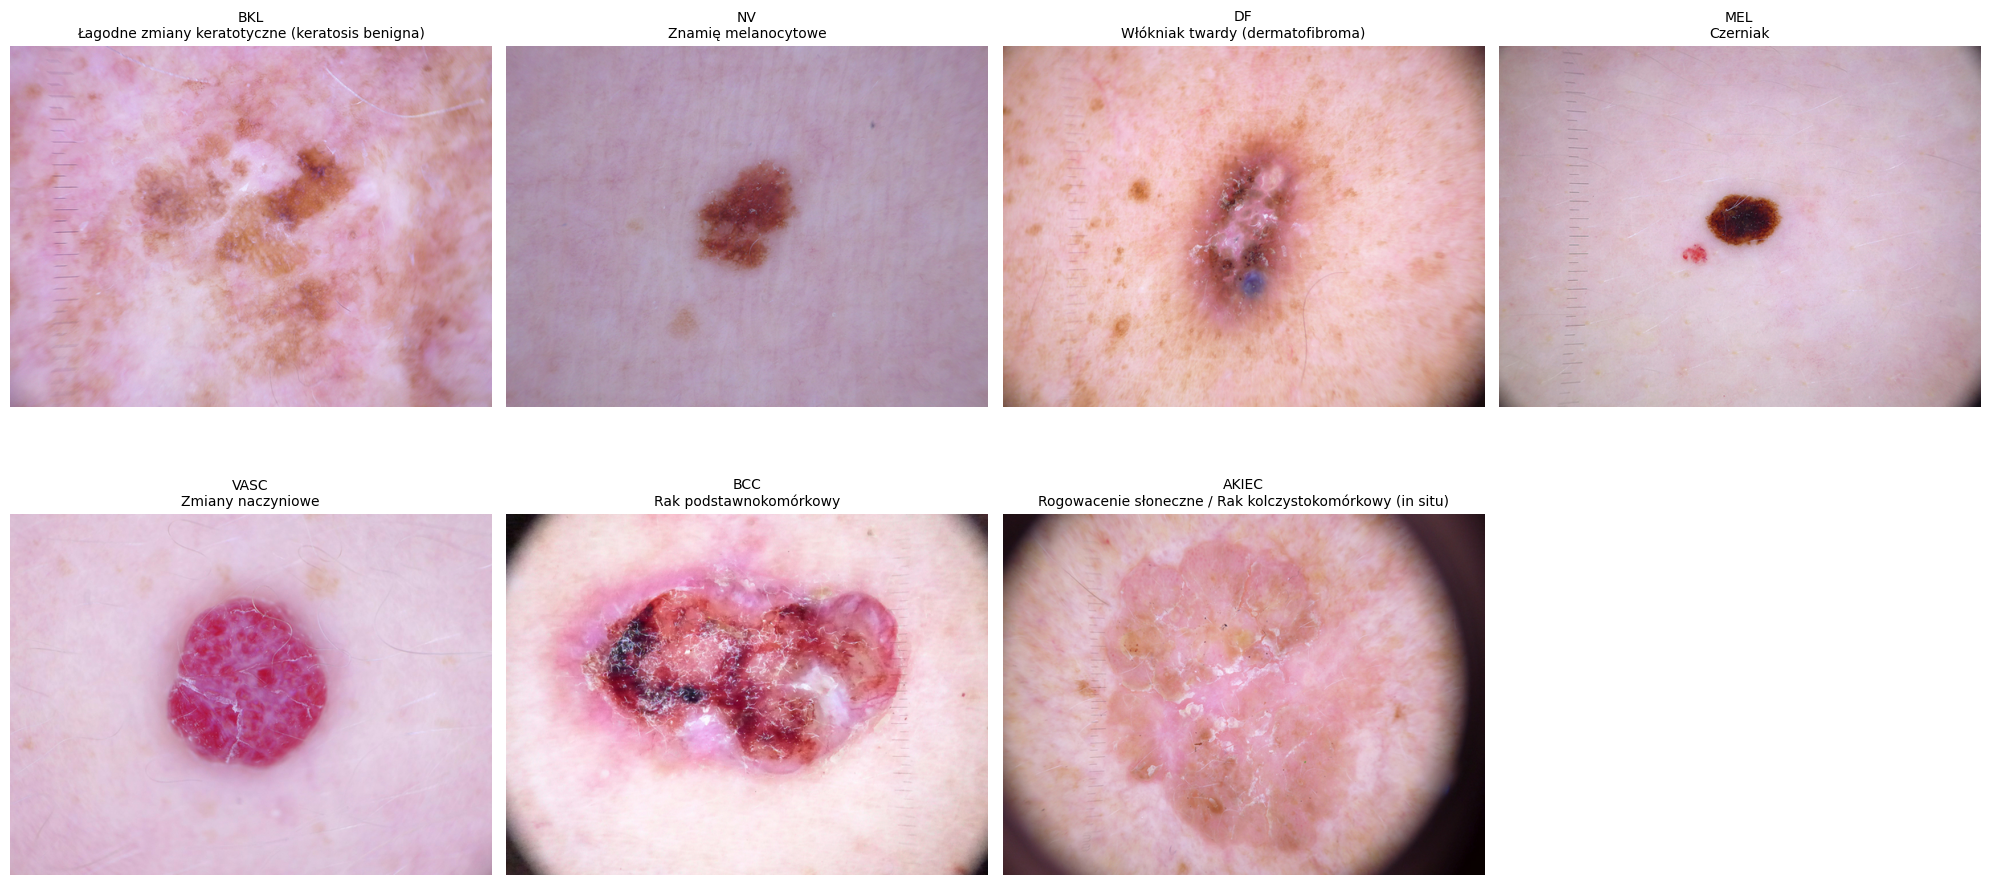


Liczba przypadków w każdej klasie:

BKL - Łagodne zmiany keratotyczne (keratosis benigna)
Liczba przypadków: 1099

NV - Znamię melanocytowe
Liczba przypadków: 6705

DF - Włókniak twardy (dermatofibroma)
Liczba przypadków: 115

MEL - Czerniak
Liczba przypadków: 1113

VASC - Zmiany naczyniowe
Liczba przypadków: 142

BCC - Rak podstawnokomórkowy
Liczba przypadków: 514

AKIEC - Rogowacenie słoneczne / Rak kolczystokomórkowy (in situ)
Liczba przypadków: 327


In [3]:
dx_descriptions = {
    'akiec': 'Rogowacenie słoneczne / Rak kolczystokomórkowy (in situ)',
    'bcc': 'Rak podstawnokomórkowy',
    'bkl': 'Łagodne zmiany keratotyczne (keratosis benigna)',
    'df': 'Włókniak twardy (dermatofibroma)',
    'nv': 'Znamię melanocytowe',
    'mel': 'Czerniak',
    'vasc': 'Zmiany naczyniowe'
}

examples = {}
for dx in df['dx'].unique():
    example = df[df['dx'] == dx].iloc[0]
    examples[dx] = example['filepath']

plt.figure(figsize=(20, 10))

for idx, (dx, img_path) in enumerate(examples.items(), 1):
    try:
        img = Image.open(img_path)
        plt.subplot(2, 4, idx)
        plt.imshow(img)
        plt.title(f"{dx.upper()}\n{dx_descriptions[dx]}", fontsize=10)
        plt.axis('off')
    except Exception as e:
        print(f"Nie udało się załadować obrazu dla klasy {dx}: {e}")

plt.tight_layout()
plt.show()

print("\nLiczba przypadków w każdej klasie:")
class_counts = df['dx'].value_counts()
for dx in df['dx'].unique():
    print(f"\n{dx.upper()} - {dx_descriptions[dx]}")
    print(f"Liczba przypadków: {class_counts[dx]}")

### **Trenowanie modelu CNN**

Poniższy kod definiuje, kompiluje i trenuje model konwolucyjnej sieci neuronowej (CNN) od podstaw:

- Definicja modelu `Sequential` z warstwami konwolucyjnymi (`Conv2D`), pooling (`MaxPooling2D`), spłaszczającą (`Flatten`), gęstą (`Dense`) i dropout (`Dropout`).
- Kompilacja modelu z optymalizatorem `Adam`, funkcją straty `categorical_crossentropy` i metryką `accuracy`.
- Ustawienie callbacku `EarlyStopping` do zatrzymania treningu przy braku poprawy.
- Wyświetlenie podsumowania modelu.
- Trenowanie modelu na zbiorze treningowym z walidacją na zbiorze walidacyjnym, z użyciem wag klas i callbacku `EarlyStopping`.
- Zapisanie wytrenowanego modelu do pliku `model_cnn.h5`.

In [4]:
print("Trenowanie modelu CNN od podstaw...")

model_cnn = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(img_size[0], img_size[1], 3)),
    MaxPooling2D((2, 2)),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model_cnn.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    mode='min',
    verbose=1
)

model_cnn.summary()

history_cnn = model_cnn.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

model_cnn.save('models/model_cnn.h5')

Trenowanie modelu CNN od podstaw...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 52, 52, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 86528)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │      11,075,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,169,863 (42.61 MB)

 Trainable params: 11,169,863 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 199s 761ms/step - accuracy: 0.3429 - loss: 1.8988 - val_accuracy: 0.4306 - val_loss: 1.5398
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 165s 658ms/step - accuracy: 0.4443 - loss: 1.7915 - val_accuracy: 0.2987 - val_loss: 1.6835
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 166s 660ms/step - accuracy: 0.4292 - loss: 1.7121 - val_accuracy: 0.4755 - val_loss: 1.2562
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 199s 648ms/step - accuracy: 0.4486 - loss: 1.5938 - val_accuracy: 0.4575 - val_loss: 1.4474
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 168s 670ms/step - accuracy: 0.4593 - loss: 1.6367 - val_accuracy: 0.4945 - val_loss: 1.2706
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 0.4624 - loss: 1.5175 - val_accuracy: 0.4266 - val_loss: 1.4547
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 163s 648ms/step - accuracy: 0.4469 - loss: 1.5351 - val_accuracy: 0.5085 - val_loss: 1.1906
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 163s 648ms/step - accuracy: 

### **Wizualizacja wyników treningu**

Poniższy kod wizualizuje wyniki treningu modelu CNN:

- Tworzenie wykresu strat treningowych i walidacyjnych w zależności od epoki.
- Tworzenie wykresu dokładności treningowej i walidacyjnej w zależności od epoki.
- Wyświetlanie wykresów obok siebie dla lepszego porównania.

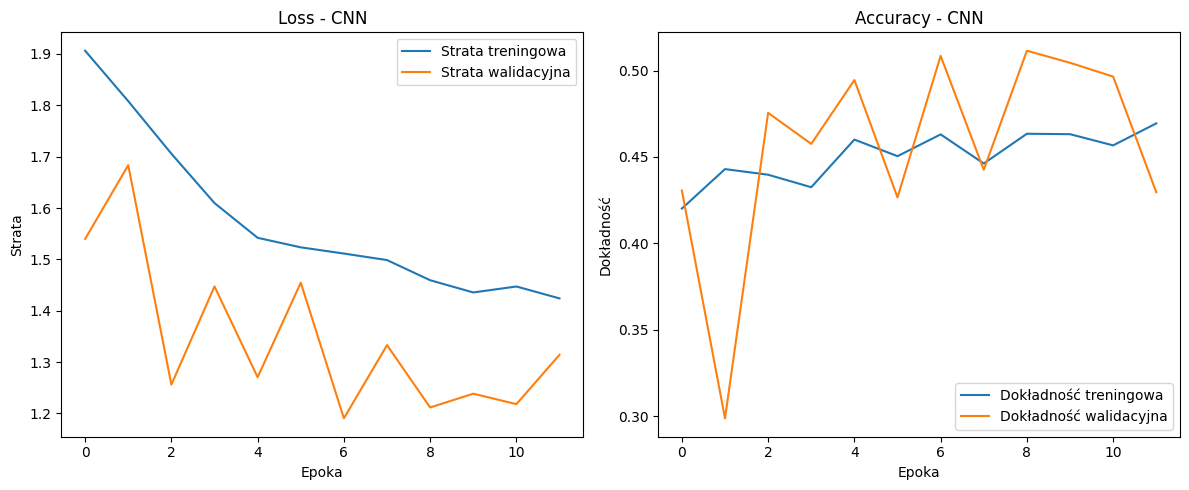

In [5]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['loss'], label='Strata treningowa')
plt.plot(history_cnn.history['val_loss'], label='Strata walidacyjna')
plt.title('Loss - CNN')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['accuracy'], label='Dokładność treningowa')
plt.plot(history_cnn.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Accuracy - CNN')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()

plt.savefig('cnn_loss_accuracy_curves.png')

plt.show()

### **Ewaluacja modelu CNN**

Poniższy kod ocenia model CNN na zbiorze testowym:

- `y_true`: Prawdziwe klasy z generatora testowego.
- `y_pred`: Przewidywane prawdopodobieństwa klas przez model.
- `y_pred_classes`: Przewidywane klasy (indeksy) przez model.
- Obliczanie i wyświetlanie macierzy pomyłek (`confusion_matrix`).
- Wyświetlanie macierzy pomyłek jako procentów.

32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 280ms/step


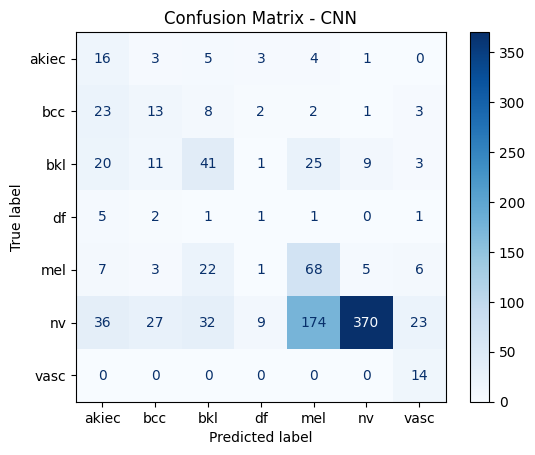

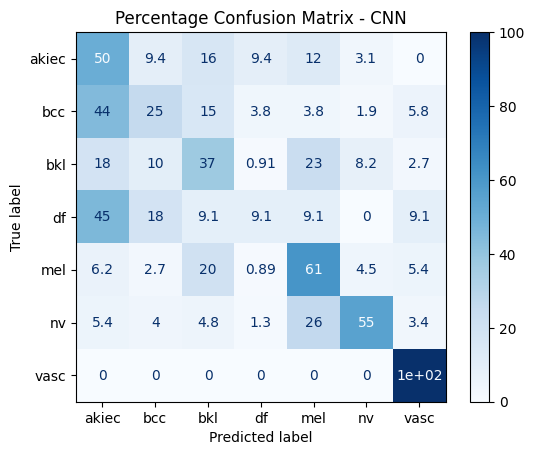

In [6]:
y_true = test_generator.classes
y_pred = model_cnn.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

cm = confusion_matrix(y_true, y_pred_classes)
cmd = ConfusionMatrixDisplay(cm, display_labels=test_generator.class_indices.keys())
cmd.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - CNN')
plt.show()

cm_percentage = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis] * 100
cmd_percentage = ConfusionMatrixDisplay(cm_percentage, display_labels=test_generator.class_indices.keys())
cmd_percentage.plot(cmap=plt.cm.Blues)
plt.title('Percentage Confusion Matrix - CNN')

plt.savefig('learning_curves_cnn.png')

plt.show()

### **Trenowanie modelu z Transfer Learningiem (MobileNetV2)**

Poniższy kod definiuje, kompiluje i trenuje model z wykorzystaniem transfer learningu na bazie MobileNetV2:

- `base_model`: Pretrenowany model MobileNetV2 bez górnych warstw, z zamrożonymi wagami.
- Definicja modelu `Sequential` z bazowym modelem, globalną warstwą pooling, gęstą warstwą i dropout.
- Kompilacja modelu z optymalizatorem `Adam`, funkcją straty `categorical_crossentropy` i metryką `accuracy`.
- Wyświetlenie podsumowania modelu.
- Trenowanie modelu na zbiorze treningowym z walidacją na zbiorze walidacyjnym, z użyciem wag klas i callbacku `EarlyStopping`.
- Zapisanie wytrenowanego modelu do pliku `model_tl.h5`.

In [7]:
print("Trenowanie modelu z Transfer Learningiem (MobileNetV2)...")

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))
base_model.trainable = False

model_tl = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model_tl.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model_tl.summary()

history_tl = model_tl.fit(
    train_generator,
    validation_data=val_generator,
    epochs=100,
    class_weight=class_weight_dict,
    callbacks=[early_stopping]
)

model_tl.save('models/model_tl.h5')

Trenowanie modelu z Transfer Learningiem (MobileNetV2)...
9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │             903 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 180s 678ms/step - accuracy: 0.1840 - loss: 2.2039 - val_accuracy: 0.3287 - val_loss: 1.7879
Epoch 2/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 166s 661ms/step - accuracy: 0.3288 - loss: 1.6744 - val_accuracy: 0.4346 - val_loss: 1.6153
Epoch 3/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 197s 642ms/step - accuracy: 0.3988 - loss: 1.5696 - val_accuracy: 0.5285 - val_loss: 1.4186
Epoch 4/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 642ms/step - accuracy: 0.4287 - loss: 1.6097 - val_accuracy: 0.5145 - val_loss: 1.4289
Epoch 5/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 160s 637ms/step - accuracy: 0.4316 - loss: 1.5103 - val_accuracy: 0.5405 - val_loss: 1.3581
Epoch 6/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 163s 649ms/step - accuracy: 0.4541 - loss: 1.4051 - val_accuracy: 0.4835 - val_loss: 1.4111
Epoch 7/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 161s 643ms/step - accuracy: 0.4669 - loss: 1.4210 - val_accuracy: 0.4665 - val_loss: 1.4192
Epoch 8/100
251/251 ━━━━━━━━━━━━━━━━━━━━ 162s 647ms/step - accuracy: 

### **Wizualizacja wyników treningu (Transfer Learning)**

Poniższy kod wizualizuje wyniki treningu modelu z transfer learningiem:

- Tworzenie wykresu strat treningowych i walidacyjnych w zależności od epoki.
- Tworzenie wykresu dokładności treningowej i walidacyjnej w zależności od epoki.
- Wyświetlanie wykresów obok siebie dla lepszego porównania.

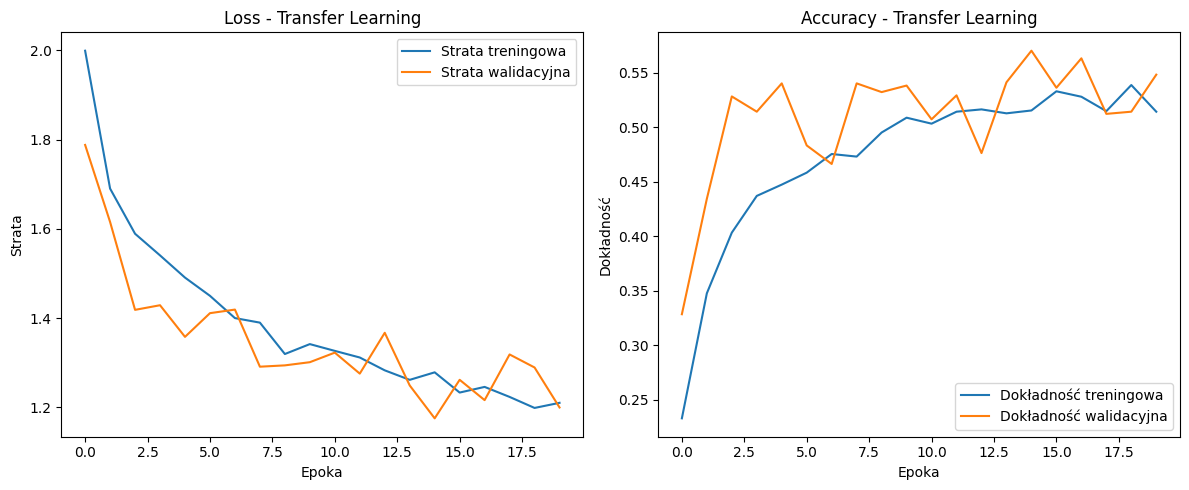

In [8]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_tl.history['loss'], label='Strata treningowa')
plt.plot(history_tl.history['val_loss'], label='Strata walidacyjna')
plt.title('Loss - Transfer Learning')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_tl.history['accuracy'], label='Dokładność treningowa')
plt.plot(history_tl.history['val_accuracy'], label='Dokładność walidacyjna')
plt.title('Accuracy - Transfer Learning')
plt.xlabel('Epoka')
plt.ylabel('Dokładność')
plt.legend()

plt.tight_layout()

plt.savefig('learning_curves_tl.png')

plt.show()

### **Ewaluacja modelu z Transfer Learningiem**

Poniższy kod ocenia model z transfer learningiem na zbiorze testowym:

- `y_true_tl`: Prawdziwe klasy z generatora testowego.
- `y_pred_tl`: Przewidywane prawdopodobieństwa klas przez model.
- `y_pred_classes_tl`: Przewidywane klasy (indeksy) przez model.
- Obliczanie i wyświetlanie macierzy pomyłek (`confusion_matrix`).
- Wyświetlanie macierzy pomyłek jako procentów.

32/32 ━━━━━━━━━━━━━━━━━━━━ 16s 389ms/step


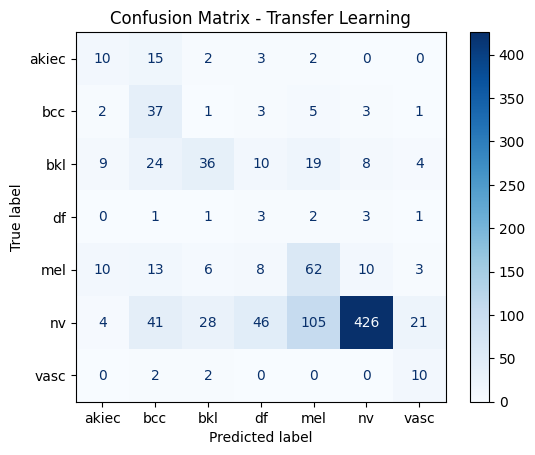

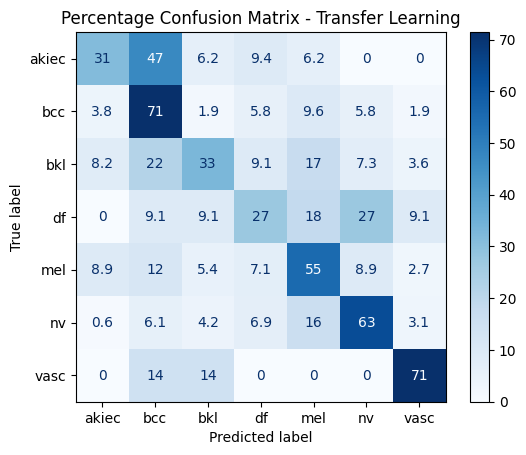

In [9]:
y_true_tl = test_generator.classes
y_pred_tl = model_tl.predict(test_generator)
y_pred_classes_tl = np.argmax(y_pred_tl, axis=1)

cm_tl = confusion_matrix(y_true_tl, y_pred_classes_tl)
cmd_tl = ConfusionMatrixDisplay(cm_tl, display_labels=test_generator.class_indices.keys())
cmd_tl.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Transfer Learning')
plt.show()

cm_percentage_tl = cm_tl.astype('float') / cm_tl.sum(axis=1)[:, np.newaxis] * 100
cmd_percentage_tl = ConfusionMatrixDisplay(cm_percentage_tl, display_labels=test_generator.class_indices.keys())
cmd_percentage_tl.plot(cmap=plt.cm.Blues)
plt.title('Percentage Confusion Matrix - Transfer Learning')

plt.savefig('percentage_confusion_matrix_tl.png')

plt.show()

### **Ewaluacja modeli CNN i Transfer Learning**

Poniższy kod ocenia modele CNN i Transfer Learning (TL) na zbiorze testowym:

- `y_true`: Prawdziwe klasy z generatora testowego.
- `y_pred_cnn`: Przewidywane prawdopodobieństwa klas przez model CNN.
- `y_pred_classes_cnn`: Przewidywane klasy (indeksy) przez model CNN.
- `y_pred_tl`: Przewidywane prawdopodobieństwa klas przez model TL.
- `y_pred_classes_tl`: Przewidywane klasy (indeksy) przez model TL.
- Obliczanie i wyświetlanie macierzy pomyłek (`confusion_matrix`) dla obu modeli.
- Wyświetlanie macierzy pomyłek jako procentów dla obu modeli.



32/32 ━━━━━━━━━━━━━━━━━━━━ 7s 213ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 14s 318ms/step
Dokładność modelu CNN: 0.52
Dokładność modelu TL: 0.58


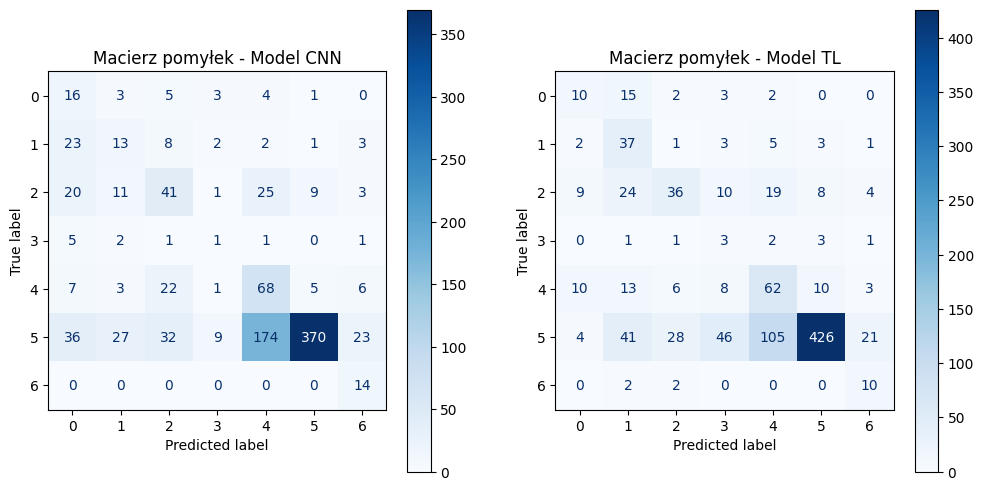

In [10]:
model_cnn = load_model('models/model_cnn.h5')
model_tl = load_model('models/model_tl.h5')

y_pred_cnn = np.argmax(model_cnn.predict(test_generator), axis=1)
y_pred_tl = np.argmax(model_tl.predict(test_generator), axis=1)

accuracy_cnn = accuracy_score(test_generator.classes, y_pred_cnn)
accuracy_tl = accuracy_score(test_generator.classes, y_pred_tl)

print(f'Dokładność modelu CNN: {accuracy_cnn:.2f}')
print(f'Dokładność modelu TL: {accuracy_tl:.2f}')

cm_cnn = confusion_matrix(test_generator.classes, y_pred_cnn)
cm_tl = confusion_matrix(test_generator.classes, y_pred_tl)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ConfusionMatrixDisplay(cm_cnn).plot(ax=ax[0], cmap='Blues')
ax[0].set_title('Macierz pomyłek - Model CNN')

ConfusionMatrixDisplay(cm_tl).plot(ax=ax[1], cmap='Blues')
ax[1].set_title('Macierz pomyłek - Model TL')

plt.show()

### **Funkcja predykcji**

Poniższa funkcja `predict_skin()` służy do klasyfikacji zdjęć zmian skórnych przy użyciu wytrenowanego modelu:

- Przyjmuje dwa parametry:
  - `model_path`: Ścieżka do zapisanego modelu (.h5)
  - `image_path`: Ścieżka do zdjęcia do analizy

- Wykonuje następujące operacje:
  - Wczytuje zapisany model
  - Przetwarza zdjęcie do formatu 224x224 pikseli
  - Normalizuje wartości pikseli do zakresu [0,1]
  - Dokonuje predykcji
  - Wyświetla wynik wraz ze zdjęciem

- Klasy wyjściowe:
  - akiec: Keratoza actinowa
  - bcc: Rak podstawnokomórkowy
  - bkl: Łagodne zmiany keratotyczne
  - df: Włókniak
  - mel: Czerniak
  - nv: Znamię melanocytowe
  - vasc: Zmiany naczyniowe

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 307ms/step
Predicted class: nv
Confidence: 99.79%


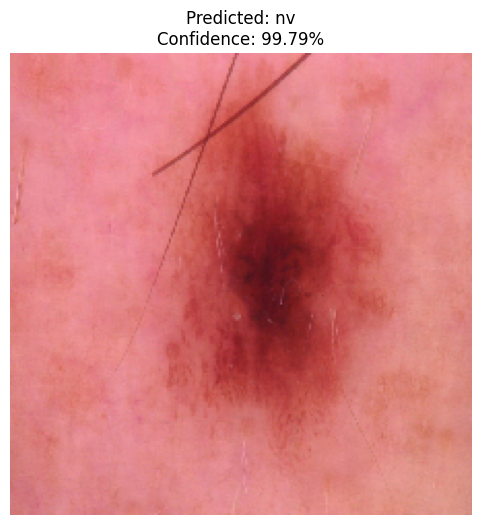

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Predicted class: nv
Confidence: 77.68%


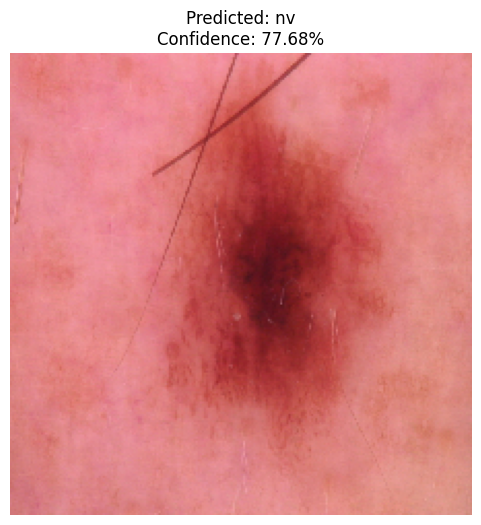

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
Predicted class: mel
Confidence: 47.47%


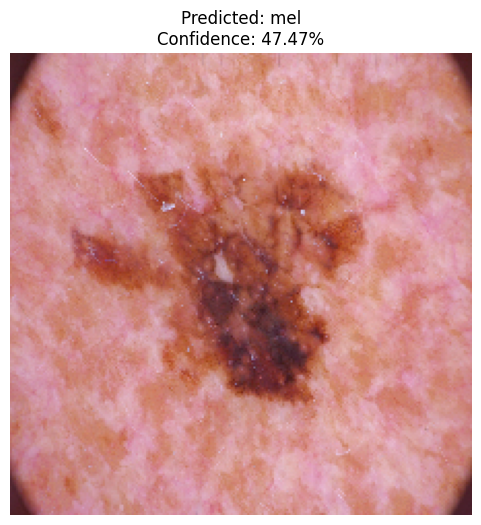

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: mel
Confidence: 46.31%


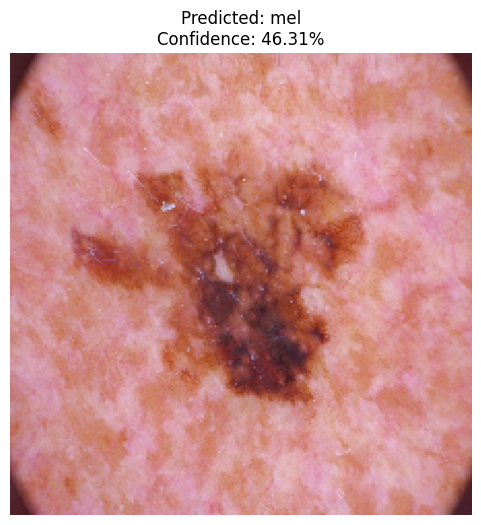

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
Predicted class: bcc
Confidence: 27.08%


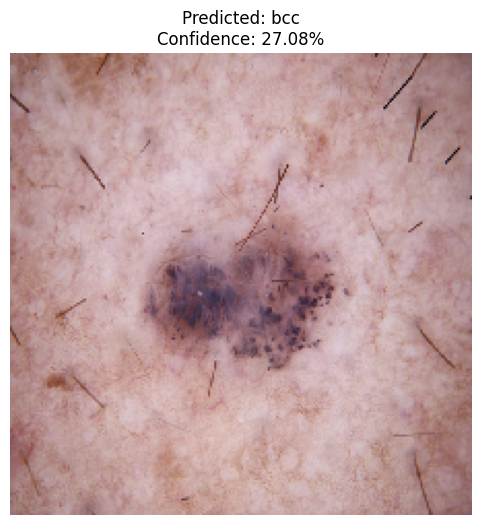

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
Predicted class: bcc
Confidence: 36.59%


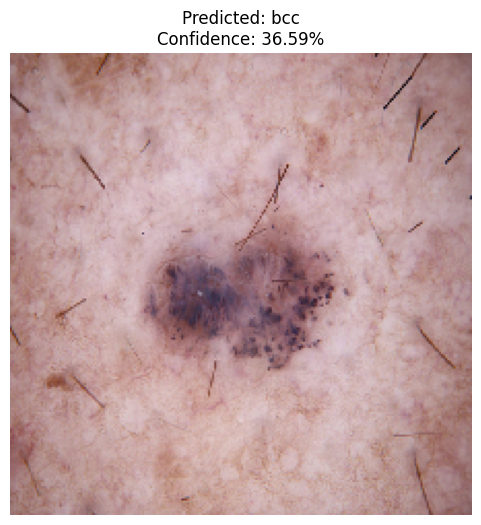

In [15]:
def predict_skin(model_path, image_path):
    model = load_model(model_path)

    img = tf.keras.preprocessing.image.load_img(
        image_path,
        target_size=(224, 224)
    )
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = img_array / 255.0
    img_array = np.expand_dims(img_array, axis=0)


    prediction = model.predict(img_array)
    class_names = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
    predicted_class = class_names[np.argmax(prediction)]
    confidence = np.max(prediction) * 100


    print(f"Predicted class: {predicted_class}")
    print(f"Confidence: {confidence:.2f}%")


    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(f"Predicted: {predicted_class}\nConfidence: {confidence:.2f}%")
    plt.axis('off')
    plt.show()


predict_skin('models/model_cnn.h5', '/content/ISIC_0024306.jpg')
predict_skin('models/model_tl.h5', '/content/ISIC_0024306.jpg')

predict_skin('models/model_cnn.h5', '/content/ISIC_0024310.jpg')
predict_skin('models/model_tl.h5', '/content/ISIC_0024310.jpg')

predict_skin('models/model_cnn.h5', '/content/ISIC_0029329.jpg')
predict_skin('models/model_tl.h5', '/content/ISIC_0029329.jpg')